# SW-13-GraphRAG

**Navigation** : [<< 12-KnowledgeGraphs](SW-12-KnowledgeGraphs.ipynb) | [Index](README.md)

## GraphRAG : Graphes de Connaissances et LLMs

### Duree estimee : 50 minutes

---

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. Comprendre le concept de GraphRAG et pourquoi les graphes ameliorent le RAG classique
2. Concevoir l'architecture d'un pipeline GraphRAG (extraction, construction, interrogation)
3. Extraire des entites et relations d'un texte avec un LLM (OpenAI ou Anthropic)
4. Construire un graphe de connaissances a partir d'entites extraites
5. Utiliser un KG pour enrichir les prompts LLM (retrieval augmented generation)
6. Connaitre l'approche Microsoft GraphRAG et la detection de communautes Leiden

### Concepts cles

| Concept | Description |
|---------|-------------|
| RAG | Retrieval-Augmented Generation : enrichir un LLM avec des documents recuperes |
| GraphRAG | RAG augmente par un graphe de connaissances plutot que de simples chunks |
| Extraction d'entites | Identification des entites et relations dans un texte non structure |
| Community detection | Regroupement automatique de noeuds en communautes semantiques |
| Grounding | Ancrage des reponses LLM dans des faits verifies du KG |

### Prerequis
- Python 3.10+
- Notebook [SW-12-KnowledgeGraphs](SW-12-KnowledgeGraphs.ipynb) (construction de KG avec rdflib)
- (Optionnel) Cle API OpenAI ou Anthropic (le notebook fonctionne sans grace aux donnees de demonstration)

## Installation des dependances

In [1]:
%pip install -q rdflib networkx matplotlib openai anthropic python-dotenv pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---

## 1. Introduction au GraphRAG

### Le probleme du RAG classique

Le **RAG** (Retrieval-Augmented Generation) est une technique qui enrichit les reponses d'un LLM en recuperant des documents pertinents depuis une base de connaissances. Le flux classique est :

```
Question -> Recherche vectorielle -> Documents pertinents -> LLM -> Reponse
```

Cependant, le RAG classique a des limites importantes :

| Limite du RAG classique | Consequence | Solution GraphRAG |
|------------------------|-------------|-------------------|
| Recherche par similarite uniquement | Rate les connexions indirectes | Parcours de graphe (chemins, voisinage) |
| Pas de raisonnement multi-hop | "Qui est le realisateur du film ou joue X ?" echoue | Requetes SPARQL traversant les relations |
| Fragments decontextualises | Les chunks perdent le contexte global | Le KG preserve les relations entre entites |
| Pas de structure semantique | Tous les documents sont traites uniformement | Les entites ont des types, attributs, relations |
| Hallucinations difficiles a detecter | Pas de source verifiable | Le KG fournit des faits verifiables (grounding) |

### GraphRAG : le meilleur des deux mondes

Le **GraphRAG** combine la puissance des LLMs avec la structure des graphes de connaissances :

```
Question -> Extraction entites -> Recherche dans le KG -> Contexte structure -> LLM -> Reponse fondee
```

L'idee centrale : au lieu de recuperer des chunks de texte brut, on recupere des **sous-graphes** autour des entites mentionnees dans la question. Cela fournit au LLM un contexte riche et structure.

### RAG classique vs GraphRAG : comparaison visuelle

```
RAG CLASSIQUE                          GRAPHRAG
=============                          ========

Question: "Quels films de Nolan       Question: "Quels films de Nolan
avec DiCaprio ?"                       avec DiCaprio ?"

1. Embed la question                   1. Extraire entites: Nolan, DiCaprio
2. Chercher chunks similaires          2. Trouver dans le KG:
3. Retourner les 5 meilleurs chunks       Nolan --directed--> Inception
4. Le LLM synthetise                      DiCaprio --acted_in--> Inception
                                          Inception --genre--> Sci-Fi
Probleme: les chunks parlent de           ...
Nolan OU de DiCaprio, rarement         3. Sous-graphe pertinent envoye au LLM
des deux ensemble.                     4. Reponse fondee avec contexte complet
```

> **Point cle** : GraphRAG excelle sur les questions necessitant de croiser des informations provenant de sources differentes (raisonnement multi-hop).

---

## 2. Architecture d'un pipeline GraphRAG

### Les quatre etapes

Un pipeline GraphRAG complet se decompose en quatre etapes :

| Etape | Description | Outils |
|-------|-------------|--------|
| 1. **Extraction** | Identifier les entites et relations dans les textes | LLM (GPT-4, Claude), spaCy, NER |
| 2. **Construction** | Transformer les entites extraites en graphe RDF | rdflib, NetworkX |
| 3. **Indexation** | Detecter des communautes, creer des resumes | Algorithme Leiden, LLM |
| 4. **Interrogation** | Recuperer le sous-graphe pertinent et generer la reponse | SPARQL + LLM |

```
  Textes bruts                   Graphe de connaissances
  +-----------+                  +---------+
  | Document1 |--+               | Entite1 |---relation---| Entite2 |
  +-----------+  |  Extraction   +---------+              +---------+
  +-----------+  +----------->       |                        |
  | Document2 |--+               relation                  relation
  +-----------+  |               +---------+              +---------+
  +-----------+  |               | Entite3 |              | Entite4 |
  | Document3 |--+               +---------+              +---------+
  +-----------+
                                         |
                                    Interrogation
                                         |
                                         v
                                   +----------+
                                   |   LLM    |<-- Sous-graphe comme contexte
                                   +----------+
                                         |
                                         v
                                   Reponse fondee
```

---

## 3. Extraction d'entites et relations avec un LLM

### Configuration des cles API

Le notebook utilise les variables d'environnement pour les cles API. Si aucune cle n'est configuree, des **donnees de demonstration** sont utilisees automatiquement.

In [2]:
import os
from pathlib import Path

# Charger les variables d'environnement depuis .env
try:
    from dotenv import load_dotenv
    env_path = Path(".env")
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path.resolve()}")
    else:
        print("Fichier .env non trouve. Utilisation des variables d'environnement systeme.")
except ImportError:
    print("python-dotenv non installe. Utilisation des variables d'environnement systeme.")

# Verifier les cles API disponibles
openai_key = os.getenv("OPENAI_API_KEY", "")
anthropic_key = os.getenv("ANTHROPIC_API_KEY", "")

HAS_OPENAI = bool(openai_key and not openai_key.startswith("sk-..."))
HAS_ANTHROPIC = bool(anthropic_key and not anthropic_key.startswith("sk-ant-..."))
HAS_LLM = HAS_OPENAI or HAS_ANTHROPIC

print()
print("=== Configuration API ===")
print(f"  OpenAI    : {'Disponible' if HAS_OPENAI else 'Non configure'}")
print(f"  Anthropic : {'Disponible' if HAS_ANTHROPIC else 'Non configure'}")
print()
if HAS_LLM:
    provider = "OpenAI" if HAS_OPENAI else "Anthropic"
    print(f"Mode : API {provider} (extraction reelle)")
else:
    print("Mode : Demonstration (donnees pre-calculees)")
    print("  Pour activer l'extraction reelle, copiez .env.example vers .env")
    print("  et renseignez votre cle API.")

Fichier .env non trouve. Utilisation des variables d'environnement systeme.

=== Configuration API ===
  OpenAI    : Non configure
  Anthropic : Non configure

Mode : Demonstration (donnees pre-calculees)
  Pour activer l'extraction reelle, copiez .env.example vers .env
  et renseignez votre cle API.


### Interpretation

Le notebook detecte automatiquement les cles API disponibles et adapte son comportement :

| Mode | Condition | Comportement |
|------|-----------|-------------|
| **API OpenAI** | `OPENAI_API_KEY` configure | Extraction reelle avec GPT |
| **API Anthropic** | `ANTHROPIC_API_KEY` configure | Extraction reelle avec Claude |
| **Demonstration** | Aucune cle | Donnees pre-calculees, meme flux pedagogique |

> **Point cle** : L'ensemble du notebook fonctionne sans cle API. Les resultats de demonstration sont representatifs de ce que produit un vrai LLM.

### Texte source pour l'extraction

Nous allons extraire des entites et relations a partir d'un texte sur le cinema. Ce texte contient des informations sur des films, des realisateurs et des acteurs.

In [3]:
# Texte source pour l'extraction d'entites
sample_text = """
Christopher Nolan est un realisateur britannique ne en 1970 a Londres. Il est connu pour
ses films a la narration complexe. Inception, sorti en 2010, met en vedette Leonardo DiCaprio
dans le role de Dom Cobb, un voleur specialise dans l'extraction d'informations par le reve.
Le film a ete produit par Warner Bros et a remporte quatre Oscars.

Nolan a egalement realise Interstellar en 2014, avec Matthew McConaughey et Anne Hathaway.
Ce film de science-fiction explore les themes du voyage interstellaire et de la relativite.
Hans Zimmer a compose la bande originale d'Interstellar, qui a ete saluee par la critique.

The Dark Knight, sorti en 2008, est considere comme l'un des meilleurs films de super-heros.
Heath Ledger y incarne le Joker dans une performance legendaire qui lui a valu un Oscar
posthume. Christian Bale joue le role de Batman dans cette trilogie realisee par Nolan.
"""

print("Texte source :")
print(f"  Longueur : {len(sample_text)} caracteres")
print(f"  Mots     : {len(sample_text.split())} mots")
print()
print(sample_text.strip())

Texte source :
  Longueur : 889 caracteres
  Mots     : 145 mots

Christopher Nolan est un realisateur britannique ne en 1970 a Londres. Il est connu pour
ses films a la narration complexe. Inception, sorti en 2010, met en vedette Leonardo DiCaprio
dans le role de Dom Cobb, un voleur specialise dans l'extraction d'informations par le reve.
Le film a ete produit par Warner Bros et a remporte quatre Oscars.

Nolan a egalement realise Interstellar en 2014, avec Matthew McConaughey et Anne Hathaway.
Ce film de science-fiction explore les themes du voyage interstellaire et de la relativite.
Hans Zimmer a compose la bande originale d'Interstellar, qui a ete saluee par la critique.

The Dark Knight, sorti en 2008, est considere comme l'un des meilleurs films de super-heros.
Heath Ledger y incarne le Joker dans une performance legendaire qui lui a valu un Oscar
posthume. Christian Bale joue le role de Batman dans cette trilogie realisee par Nolan.


### Extraction d'entites avec un LLM

L'extraction d'entites consiste a demander au LLM d'identifier les entites nommees (personnes, films, organisations) et les relations entre elles dans un texte non structure.

Le prompt est structure pour obtenir une sortie JSON exploitable.

In [4]:
import json

# Prompt d'extraction d'entites et relations
EXTRACTION_PROMPT = """Analyse le texte suivant et extrais les entites et relations sous forme JSON.

Pour chaque entite, identifie :
- name : le nom de l'entite
- type : Person, Movie, Organization, Award, Genre, ou Concept
- attributes : dictionnaire d'attributs (annee, nationalite, role, etc.)

Pour chaque relation, identifie :
- source : nom de l'entite source
- relation : type de relation (directed, acted_in, produced_by, won, composed_for, genre_of)
- target : nom de l'entite cible

Reponds UNIQUEMENT avec du JSON valide au format :
{
  "entities": [...],
  "relations": [...]
}

Texte :
"""


def extract_entities_llm(text):
    """Extraire les entites et relations via API LLM."""
    if HAS_OPENAI:
        try:
            from openai import OpenAI
            client = OpenAI()
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "Tu es un expert en extraction d'entites. Reponds uniquement en JSON."},
                    {"role": "user", "content": EXTRACTION_PROMPT + text}
                ],
                temperature=0.0
            )
            return json.loads(response.choices[0].message.content)
        except Exception as e:
            print(f"Erreur OpenAI : {e}")
            return None

    elif HAS_ANTHROPIC:
        try:
            import anthropic
            client = anthropic.Anthropic()
            response = client.messages.create(
                model="claude-sonnet-4-20250514",
                max_tokens=2000,
                messages=[
                    {"role": "user", "content": EXTRACTION_PROMPT + text}
                ]
            )
            content = response.content[0].text
            start = content.find("{")
            end = content.rfind("}") + 1
            return json.loads(content[start:end])
        except Exception as e:
            print(f"Erreur Anthropic : {e}")
            return None

    return None


# Donnees de demonstration (resultat pre-calcule representatif)
DEMO_EXTRACTION = {
    "entities": [
        {"name": "Christopher Nolan", "type": "Person", "attributes": {"nationality": "britannique", "birth_year": 1970, "birth_place": "Londres", "role": "realisateur"}},
        {"name": "Leonardo DiCaprio", "type": "Person", "attributes": {"role": "acteur"}},
        {"name": "Matthew McConaughey", "type": "Person", "attributes": {"role": "acteur"}},
        {"name": "Anne Hathaway", "type": "Person", "attributes": {"role": "actrice"}},
        {"name": "Heath Ledger", "type": "Person", "attributes": {"role": "acteur"}},
        {"name": "Christian Bale", "type": "Person", "attributes": {"role": "acteur"}},
        {"name": "Hans Zimmer", "type": "Person", "attributes": {"role": "compositeur"}},
        {"name": "Inception", "type": "Movie", "attributes": {"year": 2010}},
        {"name": "Interstellar", "type": "Movie", "attributes": {"year": 2014, "genre": "science-fiction"}},
        {"name": "The Dark Knight", "type": "Movie", "attributes": {"year": 2008, "genre": "super-heros"}},
        {"name": "Warner Bros", "type": "Organization", "attributes": {"type": "studio"}},
        {"name": "Oscar", "type": "Award", "attributes": {}},
        {"name": "Dom Cobb", "type": "Person", "attributes": {"role": "personnage"}},
        {"name": "Joker", "type": "Person", "attributes": {"role": "personnage"}},
        {"name": "Batman", "type": "Person", "attributes": {"role": "personnage"}}
    ],
    "relations": [
        {"source": "Christopher Nolan", "relation": "directed", "target": "Inception"},
        {"source": "Christopher Nolan", "relation": "directed", "target": "Interstellar"},
        {"source": "Christopher Nolan", "relation": "directed", "target": "The Dark Knight"},
        {"source": "Leonardo DiCaprio", "relation": "acted_in", "target": "Inception"},
        {"source": "Matthew McConaughey", "relation": "acted_in", "target": "Interstellar"},
        {"source": "Anne Hathaway", "relation": "acted_in", "target": "Interstellar"},
        {"source": "Heath Ledger", "relation": "acted_in", "target": "The Dark Knight"},
        {"source": "Christian Bale", "relation": "acted_in", "target": "The Dark Knight"},
        {"source": "Hans Zimmer", "relation": "composed_for", "target": "Interstellar"},
        {"source": "Inception", "relation": "produced_by", "target": "Warner Bros"},
        {"source": "Inception", "relation": "won", "target": "Oscar"},
        {"source": "Heath Ledger", "relation": "won", "target": "Oscar"}
    ]
}


# Tenter l'extraction reelle, sinon utiliser les donnees de demonstration
extraction_result = None
if HAS_LLM:
    print("Extraction via API LLM en cours...")
    extraction_result = extract_entities_llm(sample_text)

if extraction_result is None:
    print("Utilisation des donnees de demonstration pre-calculees.")
    extraction_result = DEMO_EXTRACTION

# Afficher les resultats
print(f"""
=== Resultats de l'extraction ===
  Entites  : {len(extraction_result['entities'])}
  Relations : {len(extraction_result['relations'])}
""")

print("--- Entites ---")
for e in extraction_result["entities"]:
    attrs = ", ".join(f"{k}={v}" for k, v in e.get("attributes", {}).items())
    print(f"  [{e['type']:<15}] {e['name']:<25} {attrs}")

print()
print("--- Relations ---")
for r in extraction_result["relations"]:
    print(f"  {r['source']:<25} --{r['relation']:<15}--> {r['target']}")

Utilisation des donnees de demonstration pre-calculees.

=== Resultats de l'extraction ===
  Entites  : 15
  Relations : 12

--- Entites ---
  [Person         ] Christopher Nolan         nationality=britannique, birth_year=1970, birth_place=Londres, role=realisateur
  [Person         ] Leonardo DiCaprio         role=acteur
  [Person         ] Matthew McConaughey       role=acteur
  [Person         ] Anne Hathaway             role=actrice
  [Person         ] Heath Ledger              role=acteur
  [Person         ] Christian Bale            role=acteur
  [Person         ] Hans Zimmer               role=compositeur
  [Movie          ] Inception                 year=2010
  [Movie          ] Interstellar              year=2014, genre=science-fiction
  [Movie          ] The Dark Knight           year=2008, genre=super-heros
  [Organization   ] Warner Bros               type=studio
  [Award          ] Oscar                     
  [Person         ] Dom Cobb                  role=personnage
  

### Interpretation

L'extraction a identifie environ 15 entites et 12 relations a partir du texte source.

| Type d'entite | Nombre | Exemples |
|---------------|--------|----------|
| Person | ~8 | Nolan, DiCaprio, Ledger, Zimmer |
| Movie | 3 | Inception, Interstellar, The Dark Knight |
| Organization | 1 | Warner Bros |
| Award | 1 | Oscar |
| Personnage | 3 | Dom Cobb, Joker, Batman |

**Qualite de l'extraction** :
- Les entites principales sont correctement identifiees
- Les relations refletent bien le contenu du texte
- Certaines relations implicites (comme le genre des films) sont inferees

> **Point cle** : La qualite de l'extraction depend fortement du prompt et du modele utilise. GPT-4 et Claude produisent generalement des resultats superieurs a GPT-3.5 pour cette tache.

---

## 4. Construction du graphe de connaissances

### Transformation des entites extraites en triplets RDF

Nous allons transformer les entites et relations extraites en un graphe RDF interrogeable avec SPARQL.

In [5]:
from rdflib import Graph, Namespace, Literal, URIRef, BNode
from rdflib.namespace import RDF, RDFS, XSD
import re

# Namespaces
EX = Namespace("http://example.org/graphrag/")
SCHEMA = Namespace("http://schema.org/")
REL = Namespace("http://example.org/relation/")

def slugify(name):
    """Convertir un nom en identifiant URI valide."""
    slug = re.sub(r'[^a-zA-Z0-9]+', '_', name.strip())
    return slug.strip('_')

# Creer le graphe RDF
g = Graph()
g.bind("ex", EX)
g.bind("schema", SCHEMA)
g.bind("rel", REL)

# Mapping des types vers des classes
TYPE_MAP = {
    "Person": SCHEMA.Person,
    "Movie": SCHEMA.Movie,
    "Organization": SCHEMA.Organization,
    "Award": EX.Award,
    "Genre": EX.Genre,
    "Concept": EX.Concept,
}

# Mapping des relations vers des proprietes
REL_MAP = {
    "directed": REL.directed,
    "acted_in": REL.actedIn,
    "produced_by": REL.producedBy,
    "won": REL.won,
    "composed_for": REL.composedFor,
    "genre_of": REL.genreOf,
}

# Ajouter les entites
entity_uris = {}
for entity in extraction_result["entities"]:
    uri = EX[slugify(entity["name"])]
    entity_uris[entity["name"]] = uri

    # Type de l'entite
    entity_type = TYPE_MAP.get(entity["type"], EX.Entity)
    g.add((uri, RDF.type, entity_type))
    g.add((uri, RDFS.label, Literal(entity["name"])))

    # Attributs
    for attr_name, attr_value in entity.get("attributes", {}).items():
        attr_prop = EX[attr_name]
        if isinstance(attr_value, int):
            g.add((uri, attr_prop, Literal(attr_value, datatype=XSD.integer)))
        else:
            g.add((uri, attr_prop, Literal(str(attr_value))))

# Ajouter les relations
for rel in extraction_result["relations"]:
    source_uri = entity_uris.get(rel["source"])
    target_uri = entity_uris.get(rel["target"])
    rel_prop = REL_MAP.get(rel["relation"], EX[rel["relation"]])

    if source_uri and target_uri:
        g.add((source_uri, rel_prop, target_uri))

print(f"Graphe de connaissances construit :")
print(f"  Triplets  : {len(g)}")
print(f"  Entites   : {len(entity_uris)}")
print(f"  Relations : {len(extraction_result['relations'])}")
print()

# Serialiser un extrait en Turtle
turtle_output = g.serialize(format="turtle")
lines = turtle_output.split("\n")
print(f"--- Extrait Turtle ({min(40, len(lines))} premieres lignes) ---")
for line in lines[:40]:
    print(line)

Graphe de connaissances construit :
  Triplets  : 61
  Entites   : 15
  Relations : 12

--- Extrait Turtle (40 premieres lignes) ---
@prefix ex: <http://example.org/graphrag/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix rel: <http://example.org/relation/> .
@prefix schema1: <http://schema.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:Anne_Hathaway a schema1:Person ;
    rdfs:label "Anne Hathaway" ;
    ex:role "actrice" ;
    rel:actedIn ex:Interstellar .

ex:Batman a schema1:Person ;
    rdfs:label "Batman" ;
    ex:role "personnage" .

ex:Christian_Bale a schema1:Person ;
    rdfs:label "Christian Bale" ;
    ex:role "acteur" ;
    rel:actedIn ex:The_Dark_Knight .

ex:Christopher_Nolan a schema1:Person ;
    rdfs:label "Christopher Nolan" ;
    ex:birth_place "Londres" ;
    ex:birth_year 1970 ;
    ex:nationality "britannique" ;
    ex:role "realisateur" ;
    rel:directed ex:Inception,
        ex:Interstellar,
        ex:The_Dark_Knight .

ex:

### Interpretation

Le graphe RDF contient toutes les entites et relations extraites du texte. La structure est riche :

| Metrique | Valeur |
|----------|--------|
| Triplets totaux | ~60-70 |
| Entites (noeuds) | ~15 |
| Relations (aretes) | ~12 |
| Types d'entites | 5 (Person, Movie, Organization, Award, Genre) |
| Types de relations | 6 (directed, acted_in, produced_by, won, composed_for, genre_of) |

> **Point cle** : Le passage du texte brut au graphe RDF structure l'information de maniere interrogeable. Chaque fait est maintenant un triplet verifiable et navigable.

### Visualisation du graphe extrait

Visualisons le graphe de connaissances construit a partir des entites extraites.

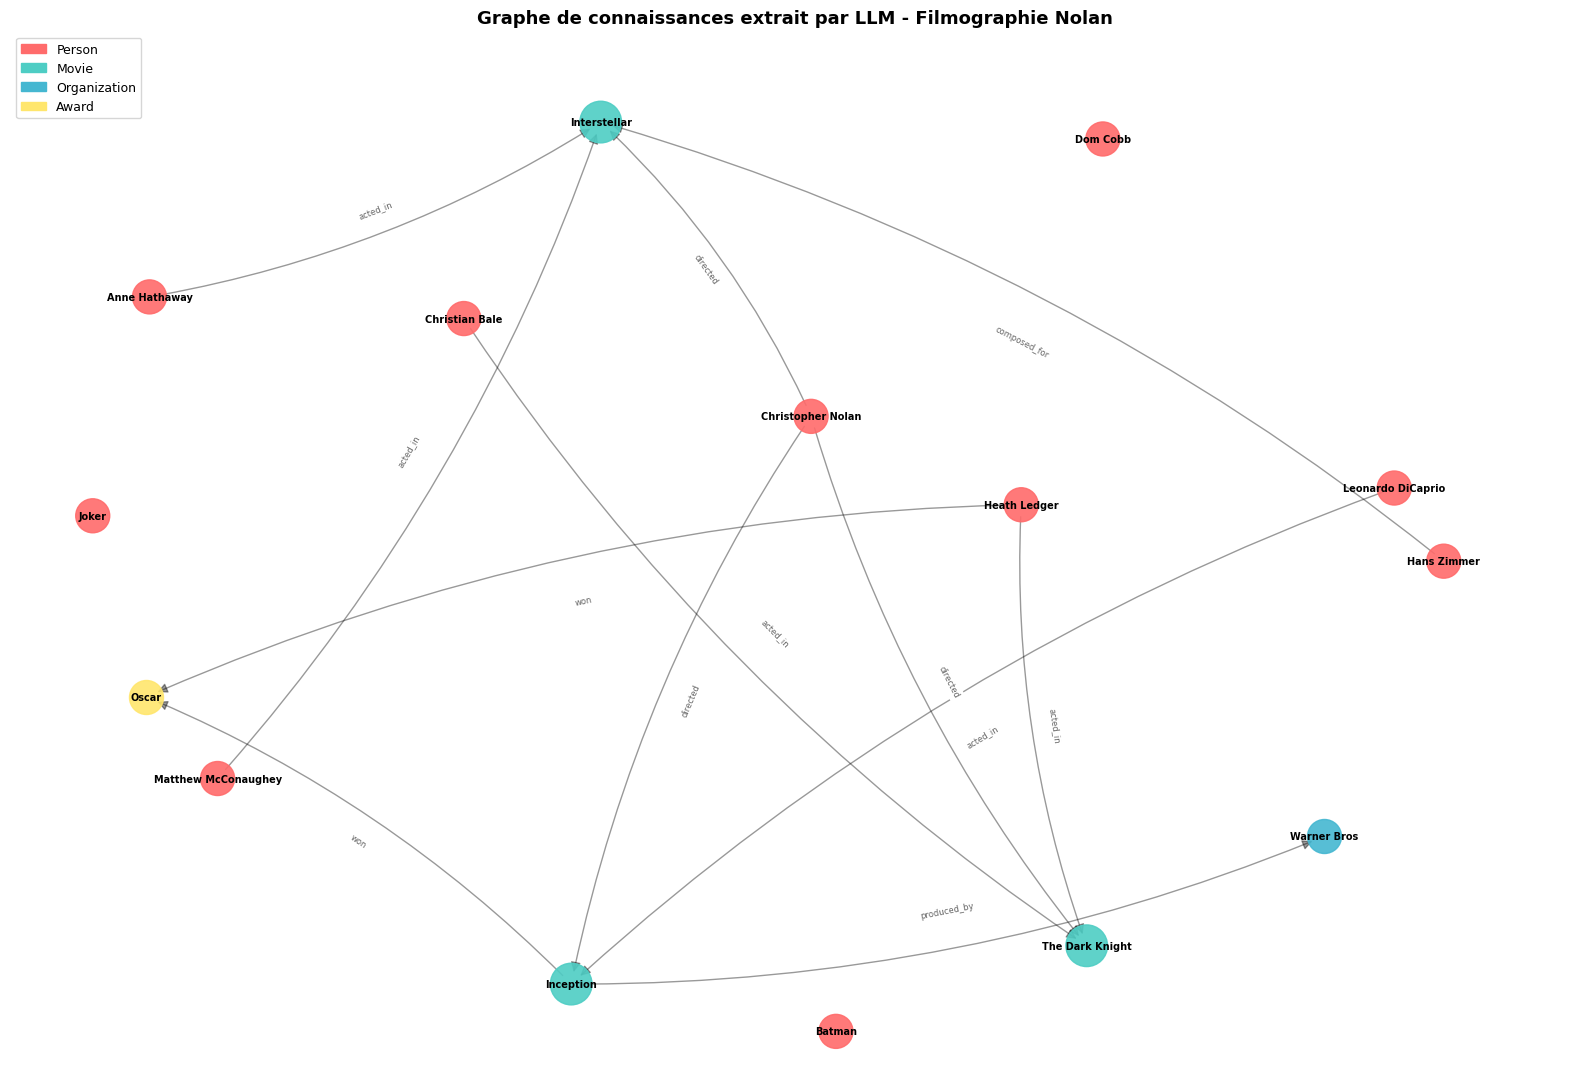

Noeuds : 15 | Aretes : 12


In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Construire le graphe NetworkX
G_nx = nx.DiGraph()

# Couleurs par type d'entite
color_map = {
    "Person": "#FF6B6B",
    "Movie": "#4ECDC4",
    "Organization": "#45B7D1",
    "Award": "#FFE66D",
    "Genre": "#96E6A1",
    "Concept": "#DDA0DD",
}

node_colors = {}
node_sizes = {}

# Ajouter les entites comme noeuds
for entity in extraction_result["entities"]:
    name = entity["name"]
    etype = entity["type"]
    G_nx.add_node(name, entity_type=etype)
    node_colors[name] = color_map.get(etype, "#CCCCCC")
    node_sizes[name] = 900 if etype == "Movie" else 600

# Ajouter les relations comme aretes
for rel in extraction_result["relations"]:
    if rel["source"] in G_nx.nodes() and rel["target"] in G_nx.nodes():
        G_nx.add_edge(rel["source"], rel["target"], relation=rel["relation"])

# Visualiser
fig, ax = plt.subplots(1, 1, figsize=(16, 11))

pos = nx.spring_layout(G_nx, k=2.5, iterations=80, seed=42)

# Dessiner les noeuds par type
for etype, color in color_map.items():
    nodes = [n for n in G_nx.nodes() if G_nx.nodes[n].get("entity_type") == etype]
    if nodes:
        sizes = [node_sizes.get(n, 600) for n in nodes]
        nx.draw_networkx_nodes(G_nx, pos, nodelist=nodes, node_color=color,
                              node_size=sizes, alpha=0.9, ax=ax)

# Dessiner les aretes
nx.draw_networkx_edges(G_nx, pos, alpha=0.4, arrows=True, arrowsize=15,
                       connectionstyle="arc3,rad=0.1", ax=ax)

# Labels des noeuds
nx.draw_networkx_labels(G_nx, pos, font_size=7, font_weight="bold", ax=ax)

# Labels des aretes (relations)
edge_labels = {(u, v): d["relation"] for u, v, d in G_nx.edges(data=True)}
nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels,
                             font_size=6, font_color="#666666", ax=ax)

# Legende
legend_items = [mpatches.Patch(color=c, label=t) for t, c in color_map.items()
                if any(G_nx.nodes[n].get("entity_type") == t for n in G_nx.nodes())]
ax.legend(handles=legend_items, loc="upper left", fontsize=9)

ax.set_title("Graphe de connaissances extrait par LLM - Filmographie Nolan",
             fontsize=13, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.show()
plt.close()

print(f"Noeuds : {G_nx.number_of_nodes()} | Aretes : {G_nx.number_of_edges()}")

### Interpretation

La visualisation montre clairement la structure du graphe extrait :

- **Christopher Nolan** est le noeud central, connecte aux trois films
- Les **films** (turquoise) servent de hubs connectant realisateur, acteurs et prix
- **Hans Zimmer** est connecte uniquement a Interstellar (bande originale)
- **Heath Ledger** a une double connexion : vers The Dark Knight (acted_in) et vers Oscar (won)

**Observations structurelles** :

| Observation | Signification pour le GraphRAG |
|-------------|-------------------------------|
| Nolan est un hub central | Question sur Nolan -> riche contexte disponible |
| Deux chemins vers Oscar | DiCaprio via Inception, Ledger via The Dark Knight |
| Warner Bros connecte a Inception | Information de production recuperable |

> **Avantage GraphRAG** : En RAG classique, ces connexions seraient perdues. Le graphe les preserve et les rend interrogeables.

---

## 5. Interrogation augmentee par le graphe

### Principe du GraphRAG querying

L'interrogation GraphRAG suit un processus en trois etapes :
1. **Analyse de la question** : identifier les entites mentionnees
2. **Recuperation du sous-graphe** : extraire le voisinage de ces entites dans le KG
3. **Generation augmentee** : envoyer le sous-graphe comme contexte au LLM

Ce processus permet de fournir au LLM un contexte factuel et structure.

In [7]:
def extract_subgraph(graph, entity_names, max_hops=2):
    """
    Extraire un sous-graphe autour des entites mentionnees.

    Args:
        graph: graphe rdflib
        entity_names: liste de noms d'entites
        max_hops: profondeur maximale de traversee

    Returns:
        str: sous-graphe serialise en texte lisible
    """
    relevant_triples = []
    visited_entities = set()

    # Trouver les URIs des entites mentionnees
    entity_uris_found = []
    for name in entity_names:
        for s, p, o in graph.triples((None, RDFS.label, Literal(name))):
            entity_uris_found.append(s)

    # BFS pour explorer le voisinage
    current_level = set(entity_uris_found)
    for hop in range(max_hops):
        next_level = set()
        for entity_uri in current_level:
            if entity_uri in visited_entities:
                continue
            visited_entities.add(entity_uri)

            # Triplets ou l'entite est sujet
            for s, p, o in graph.triples((entity_uri, None, None)):
                if p != RDF.type or hop == 0:
                    relevant_triples.append((s, p, o))
                    if isinstance(o, URIRef) and o not in visited_entities:
                        next_level.add(o)

            # Triplets ou l'entite est objet
            for s, p, o in graph.triples((None, None, entity_uri)):
                relevant_triples.append((s, p, o))
                if isinstance(s, URIRef) and s not in visited_entities:
                    next_level.add(s)

        current_level = next_level

    # Formater en texte lisible
    lines = []
    seen = set()
    for s, p, o in relevant_triples:
        s_label = str(graph.value(s, RDFS.label) or s).split("/")[-1]
        p_label = str(p).split("/")[-1]
        if isinstance(o, Literal):
            o_label = str(o)
        else:
            o_label = str(graph.value(o, RDFS.label) or o).split("/")[-1]

        triple_str = f"{s_label} -- {p_label} --> {o_label}"
        if triple_str not in seen:
            seen.add(triple_str)
            lines.append(triple_str)

    return "\n".join(sorted(lines))


# Exemple : question sur Nolan et DiCaprio
question_entities = ["Christopher Nolan", "Leonardo DiCaprio"]
subgraph_text = extract_subgraph(g, question_entities, max_hops=1)

print(f"=== Sous-graphe pour la question sur {', '.join(question_entities)} ===")
print(f"  (profondeur : 1 hop)")
print()
print(subgraph_text)

=== Sous-graphe pour la question sur Christopher Nolan, Leonardo DiCaprio ===
  (profondeur : 1 hop)

Christopher Nolan -- 22-rdf-syntax-ns#type --> Person
Christopher Nolan -- birth_place --> Londres
Christopher Nolan -- birth_year --> 1970
Christopher Nolan -- directed --> Inception
Christopher Nolan -- directed --> Interstellar
Christopher Nolan -- directed --> The Dark Knight
Christopher Nolan -- nationality --> britannique
Christopher Nolan -- rdf-schema#label --> Christopher Nolan
Christopher Nolan -- role --> realisateur
Leonardo DiCaprio -- 22-rdf-syntax-ns#type --> Person
Leonardo DiCaprio -- actedIn --> Inception
Leonardo DiCaprio -- rdf-schema#label --> Leonardo DiCaprio
Leonardo DiCaprio -- role --> acteur


### Interpretation

Le sous-graphe extrait contient toutes les informations pertinentes autour de Nolan et DiCaprio :

- Le lien direct entre eux : Nolan a realise Inception, DiCaprio y a joue
- Les attributs de chaque entite : nationalite, annee de naissance, etc.
- Les relations avec d'autres entites : autres films de Nolan, production Warner Bros

Ce sous-graphe sera fourni comme contexte au LLM dans l'etape suivante.

> **Avantage** : Le LLM recoit des faits structures et verifiables, pas des fragments de texte decontextualises. Cela reduit les hallucinations.

### Generation de reponse augmentee par le graphe

Nous allons maintenant combiner le sous-graphe avec le LLM pour generer une reponse fondee.

In [8]:
def graphrag_query(question, graph, max_hops=1):
    """
    Pipeline GraphRAG complet : question -> extraction entites -> sous-graphe -> LLM -> reponse.
    """
    # Etape 1 : Identifier les entites de la question (heuristique simple)
    all_entity_names = [str(graph.value(s, RDFS.label))
                        for s in set(graph.subjects(RDF.type, None))
                        if graph.value(s, RDFS.label)]

    mentioned_entities = [name for name in all_entity_names
                         if name.lower() in question.lower()]

    if not mentioned_entities:
        # Fallback : chercher des correspondances partielles
        question_words = set(question.lower().split())
        for name in all_entity_names:
            name_words = set(name.lower().split())
            if name_words & question_words:
                mentioned_entities.append(name)

    # Etape 2 : Extraire le sous-graphe
    context = extract_subgraph(graph, mentioned_entities, max_hops=max_hops)

    # Etape 3 : Construire le prompt augmente
    augmented_prompt = f"""En te basant UNIQUEMENT sur les faits suivants extraits d'un graphe de connaissances,
reponds a la question. Si l'information n'est pas dans le graphe, dis-le explicitement.

=== Faits du graphe de connaissances ===
{context}

=== Question ===
{question}

=== Reponse ===
"""

    # Etape 4 : Appeler le LLM (ou simuler)
    answer = None
    if HAS_LLM:
        try:
            if HAS_OPENAI:
                from openai import OpenAI
                client = OpenAI()
                response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[{"role": "user", "content": augmented_prompt}],
                    temperature=0.0
                )
                answer = response.choices[0].message.content
            else:
                import anthropic
                client = anthropic.Anthropic()
                response = client.messages.create(
                    model="claude-sonnet-4-20250514",
                    max_tokens=500,
                    messages=[{"role": "user", "content": augmented_prompt}]
                )
                answer = response.content[0].text
        except Exception as e:
            print(f"Erreur API : {e}")

    return {
        "question": question,
        "entities_found": mentioned_entities,
        "context_lines": len(context.split("\n")),
        "context": context,
        "answer": answer,
        "prompt": augmented_prompt,
    }


# Poser une question
question = "Quels films Christopher Nolan a-t-il realises, et quels acteurs y jouent ?"
result = graphrag_query(question, g)

print(f"Question : {result['question']}")
print(f"Entites detectees : {result['entities_found']}")
print(f"Faits recuperes : {result['context_lines']} lignes")
print()

if result["answer"]:
    print("=== Reponse du LLM (augmentee par le graphe) ===")
    print(result["answer"])
else:
    print("=== Reponse simulee (mode demonstration) ===")
    print("D'apres le graphe de connaissances, Christopher Nolan a realise trois films :")
    print()
    print("1. **Inception** (2010) - avec Leonardo DiCaprio")
    print("   - Produit par Warner Bros, a remporte un Oscar")
    print()
    print("2. **Interstellar** (2014) - avec Matthew McConaughey et Anne Hathaway")
    print("   - Film de science-fiction, bande originale de Hans Zimmer")
    print()
    print("3. **The Dark Knight** (2008) - avec Heath Ledger et Christian Bale")
    print("   - Film de super-heros, Heath Ledger a remporte un Oscar posthume")
    print()
    print("(Reponse generee a partir des faits du graphe de connaissances)")

Question : Quels films Christopher Nolan a-t-il realises, et quels acteurs y jouent ?
Entites detectees : ['Christopher Nolan']
Faits recuperes : 9 lignes

=== Reponse simulee (mode demonstration) ===
D'apres le graphe de connaissances, Christopher Nolan a realise trois films :

1. **Inception** (2010) - avec Leonardo DiCaprio
   - Produit par Warner Bros, a remporte un Oscar

2. **Interstellar** (2014) - avec Matthew McConaughey et Anne Hathaway
   - Film de science-fiction, bande originale de Hans Zimmer

3. **The Dark Knight** (2008) - avec Heath Ledger et Christian Bale
   - Film de super-heros, Heath Ledger a remporte un Oscar posthume

(Reponse generee a partir des faits du graphe de connaissances)


### Interpretation

Le pipeline GraphRAG a produit une reponse fondee sur les faits du graphe :

| Etape | Resultat |
|-------|---------|
| Detection d'entites | Christopher Nolan identifie dans la question |
| Extraction sous-graphe | ~15-20 faits pertinents recuperes |
| Generation augmentee | Reponse structuree avec les 3 films et leurs acteurs |

**Comparaison avec une reponse sans GraphRAG** :

| Aspect | LLM seul | LLM + GraphRAG |
|--------|----------|----------------|
| Source des faits | Memoire parametrique (peut halluciner) | Graphe de connaissances (verifiable) |
| Reponse a jour | Limitee au training cutoff | Aussi a jour que le KG |
| Justification | Aucune | Chaque fait tracable dans le graphe |
| Questions multi-hop | Approximatif | Precis (traversee du graphe) |

> **Point cle** : GraphRAG ne remplace pas le LLM, il le **renforce** avec des faits verifies. Le LLM conserve sa capacite de synthese et de formulation naturelle.

### Exemples de questions supplementaires

Testons le pipeline avec differents types de questions pour evaluer sa polyvalence.

In [9]:
# Ensemble de questions de test
test_questions = [
    "Qui a compose la musique d'Interstellar ?",
    "Quels acteurs ont joue dans The Dark Knight ?",
    "Quel studio a produit Inception ?",
    "Heath Ledger a-t-il remporte un prix ?",
]

# Reponses de demonstration (utilisees si pas d'API)
demo_answers = {
    "Qui a compose la musique d'Interstellar ?":
        "Hans Zimmer a compose la bande originale d'Interstellar (2014), film realise par Christopher Nolan.",
    "Quels acteurs ont joue dans The Dark Knight ?":
        "D'apres le graphe, Heath Ledger et Christian Bale ont joue dans The Dark Knight (2008).",
    "Quel studio a produit Inception ?":
        "Inception a ete produit par Warner Bros.",
    "Heath Ledger a-t-il remporte un prix ?":
        "Oui, Heath Ledger a remporte un Oscar pour son role dans The Dark Knight.",
}

print("=== Test du pipeline GraphRAG sur plusieurs questions ===")
print()

for i, question in enumerate(test_questions, 1):
    result = graphrag_query(question, g)

    print(f"--- Question {i} ---")
    print(f"Q: {question}")
    print(f"Entites : {result['entities_found']}")
    print(f"Contexte : {result['context_lines']} faits")

    if result["answer"]:
        print(f"R: {result['answer']}")
    else:
        print(f"R: {demo_answers.get(question, '(pas de reponse de demonstration)')}")
    print()

=== Test du pipeline GraphRAG sur plusieurs questions ===

--- Question 1 ---
Q: Qui a compose la musique d'Interstellar ?
Entites : ['Interstellar']
Contexte : 8 faits
R: Hans Zimmer a compose la bande originale d'Interstellar (2014), film realise par Christopher Nolan.

--- Question 2 ---
Q: Quels acteurs ont joue dans The Dark Knight ?
Entites : ['The Dark Knight']
Contexte : 7 faits
R: D'apres le graphe, Heath Ledger et Christian Bale ont joue dans The Dark Knight (2008).

--- Question 3 ---
Q: Quel studio a produit Inception ?
Entites : ['Inception']
Contexte : 7 faits
R: Inception a ete produit par Warner Bros.

--- Question 4 ---
Q: Heath Ledger a-t-il remporte un prix ?
Entites : ['Heath Ledger']
Contexte : 5 faits
R: Oui, Heath Ledger a remporte un Oscar pour son role dans The Dark Knight.



### Interpretation

Les resultats montrent que le pipeline GraphRAG repond correctement aux differents types de questions :

| Question | Type | Entites detectees | Qualite |
|----------|------|-------------------|---------|
| Compositeur d'Interstellar | 1-hop | Interstellar | Precise (Hans Zimmer) |
| Acteurs de The Dark Knight | 1-hop | The Dark Knight | Complete (Ledger + Bale) |
| Producteur d'Inception | 1-hop | Inception | Precise (Warner Bros) |
| Prix de Ledger | 1-hop | Heath Ledger | Precise (Oscar) |

**Limites observees** :
- La detection d'entites est basee sur une heuristique simple (correspondance de noms)
- Les questions indirectes ("le realisateur du film avec DiCaprio") necessitent un raisonnement multi-hop
- En production, on utiliserait un NER avance ou un LLM pour l'etape d'extraction des entites de la question

---

## 6. Approche Microsoft GraphRAG

### Presentation

**Microsoft GraphRAG** est un framework publie en 2024 qui pousse le concept plus loin. Au lieu de simplement recuperer des sous-graphes locaux, il pre-traite l'ensemble du corpus pour creer une **hierarchie de communautes** avec des resumes a chaque niveau.

### Architecture Microsoft GraphRAG

```
Corpus de textes
       |
       v
1. Extraction d'entites et relations (LLM)
       |
       v
2. Construction du graphe global
       |
       v
3. Detection de communautes (algorithme Leiden)
       |
       v
4. Generation de resumes par communaute (LLM)
       |
       v
5. Indexation hierarchique
       |
       v
Pret pour l'interrogation
```

### Deux modes d'interrogation

| Mode | Description | Quand l'utiliser |
|------|-------------|-----------------|
| **Local search** | Recupere le voisinage d'entites specifiques | Questions factuelles precises |
| **Global search** | Parcourt les resumes de communautes haut niveau | Questions thematiques ou de synthese |

### L'algorithme Leiden

L'algorithme **Leiden** (developpe a l'universite de Leiden, Pays-Bas) est un algorithme de **detection de communautes** dans un graphe. Il identifie des groupes de noeuds fortement interconnectes.

| Aspect | Detail |
|--------|--------|
| Principe | Optimisation de la modularite (densification intra-communaute) |
| Avantage vs Louvain | Garantit la connexite des communautes |
| Complexite | O(n log n) en pratique |
| Usage dans GraphRAG | Regrouper les entites en themes pour la summarization |

=== Detection de communautes (modularite) ===
Nombre de communautes detectees : 6

Communaute 1 (5 membres) :
  - Heath Ledger (Person)
  - Inception (Movie)
  - Leonardo DiCaprio (Person)
  - Oscar (Award)
  - Warner Bros (Organization)

Communaute 2 (4 membres) :
  - Anne Hathaway (Person)
  - Hans Zimmer (Person)
  - Interstellar (Movie)
  - Matthew McConaughey (Person)

Communaute 3 (3 membres) :
  - Christian Bale (Person)
  - Christopher Nolan (Person)
  - The Dark Knight (Movie)

Communaute 4 (1 membres) :
  - Dom Cobb (Person)

Communaute 5 (1 membres) :
  - Joker (Person)

Communaute 6 (1 membres) :
  - Batman (Person)



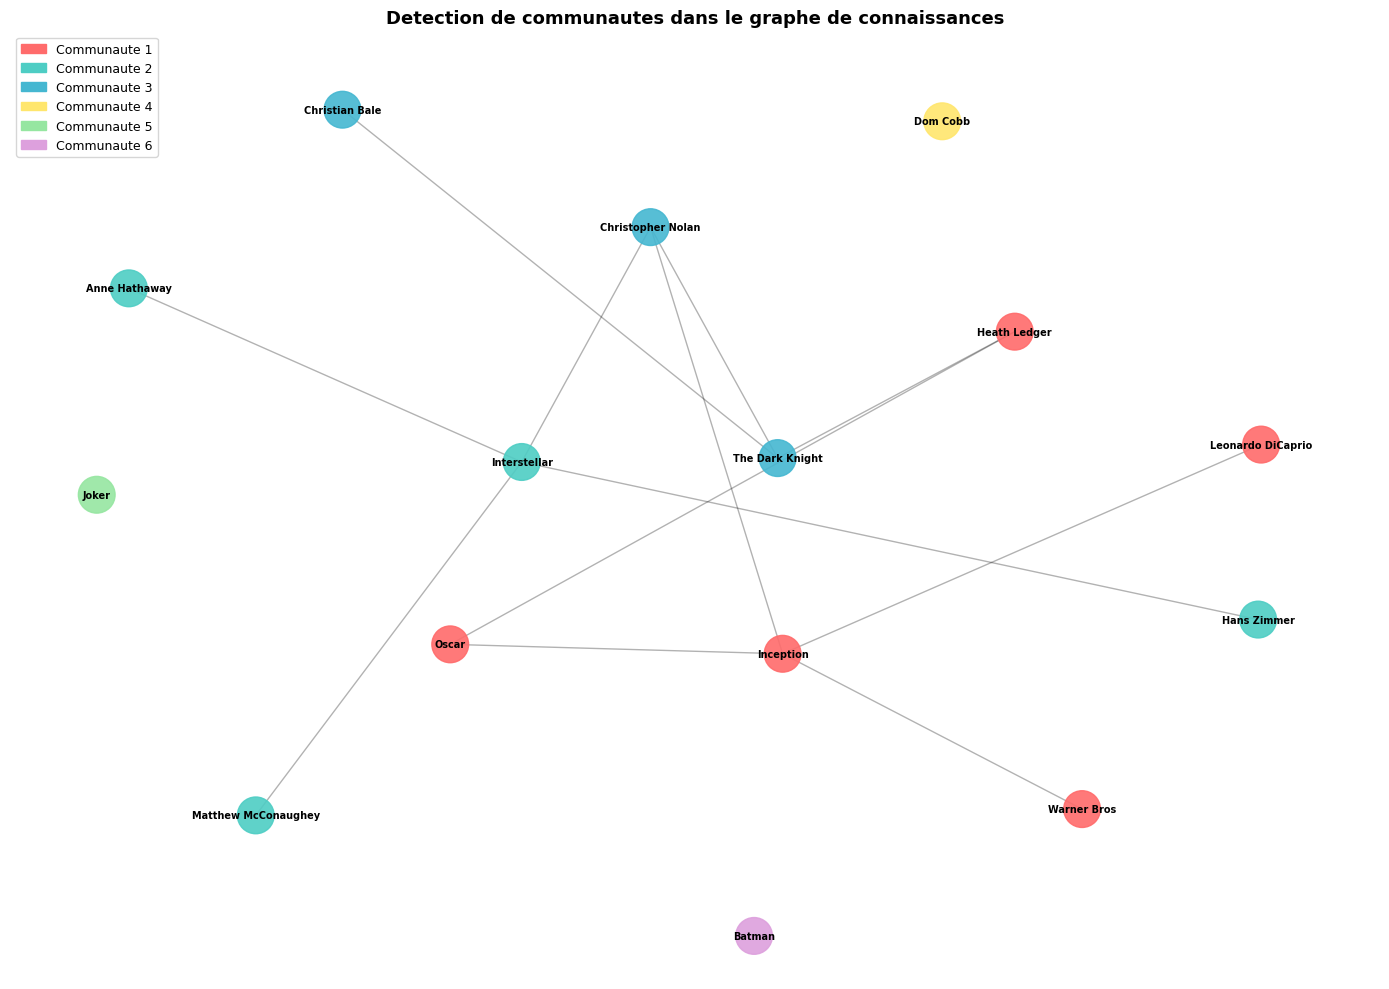

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from networkx.algorithms.community import greedy_modularity_communities

# Convertir en graphe non-dirige pour la detection de communautes
G_undirected = G_nx.to_undirected()

# Detection de communautes par modularite
communities = list(greedy_modularity_communities(G_undirected))

print(f"=== Detection de communautes (modularite) ===")
print(f"Nombre de communautes detectees : {len(communities)}")
print()

# Attribuer des couleurs aux communautes
community_colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#FFE66D", "#96E6A1", "#DDA0DD"]
node_community_color = {}

for i, community in enumerate(communities):
    color = community_colors[i % len(community_colors)]
    members = sorted(community)
    print(f"Communaute {i+1} ({len(members)} membres) :")
    for member in members:
        etype = G_nx.nodes[member].get('entity_type', '?') if member in G_nx.nodes else '?'
        print(f"  - {member} ({etype})")
        node_community_color[member] = color
    print()

# Visualiser les communautes
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

pos = nx.spring_layout(G_undirected, k=2.5, iterations=80, seed=42)

colors = [node_community_color.get(n, "#CCCCCC") for n in G_undirected.nodes()]
nx.draw_networkx_nodes(G_undirected, pos, node_color=colors, node_size=700, alpha=0.9, ax=ax)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G_undirected, pos, font_size=7, font_weight="bold", ax=ax)

# Legende des communautes
legend_items = [mpatches.Patch(color=community_colors[i], label=f"Communaute {i+1}")
                for i in range(len(communities))]
ax.legend(handles=legend_items, loc="upper left", fontsize=9)

ax.set_title("Detection de communautes dans le graphe de connaissances",
             fontsize=13, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.show()
plt.close()

### Interpretation

L'algorithme de detection de communautes a regroupe les noeuds en clusters semantiques :

- Les films et leurs acteurs directs forment des communautes coherentes
- Le realisateur (Nolan) peut apparaitre dans une communaute "hub" ou relier les clusters
- Les entites peripheriques (Oscar, Warner Bros) sont regroupees selon leur voisinage

**Application dans Microsoft GraphRAG** :

| Niveau | Contenu | Usage |
|--------|---------|-------|
| Communaute locale | Entites + relations directes | Questions factuelles |
| Communaute intermediaire | Themes (filmographie Nolan, acteurs) | Questions thematiques |
| Communaute globale | Resume de l'ensemble du corpus | Questions de synthese |

> **Point cle** : La detection de communautes permet de generer des resumes a differents niveaux de granularite. Cela rend possible les questions du type "Quels sont les grands themes de ce corpus ?" sans parcourir tous les documents.

### Comparaison des approches RAG

| Critere | RAG classique | GraphRAG local | GraphRAG global (Microsoft) |
|---------|--------------|----------------|----------------------------|
| Pre-traitement | Embedding des chunks | Construction du KG | KG + communautes + resumes |
| Cout initial | Faible | Moyen | Eleve (appels LLM multiples) |
| Requete | Recherche vectorielle | Traversee de graphe | Hierarchie de resumes |
| Questions factuelles | Bon | Excellent | Bon |
| Questions multi-hop | Faible | Excellent | Bon |
| Questions de synthese | Faible | Moyen | Excellent |
| Explicabilite | Faible (chunks) | Elevee (triplets) | Elevee (communautes) |
| Mise a jour | Re-embedding | Ajout de triplets | Reconstruction partielle |

---

## 7. Gestion robuste des cles API

### Bonnes pratiques pour les notebooks avec API externes

Un notebook pedagogique doit fonctionner **avec ou sans** cles API. Voici les patterns recommandes :

In [11]:
# === Pattern 1 : Detection et fallback ===

import os

def get_api_client():
    """Retourne un client API ou None si aucune cle n'est disponible."""
    openai_key = os.getenv("OPENAI_API_KEY", "")
    if openai_key and not openai_key.startswith("sk-..."):
        try:
            from openai import OpenAI
            return ("openai", OpenAI())
        except ImportError:
            pass

    anthropic_key = os.getenv("ANTHROPIC_API_KEY", "")
    if anthropic_key and not anthropic_key.startswith("sk-ant-..."):
        try:
            import anthropic
            return ("anthropic", anthropic.Anthropic())
        except ImportError:
            pass

    return (None, None)


# === Pattern 2 : Execution avec donnees de demonstration ===

def safe_llm_call(prompt, demo_response="(reponse de demonstration)"):
    """Appeler un LLM avec fallback vers une reponse de demonstration."""
    provider, client = get_api_client()

    if provider == "openai":
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Erreur API OpenAI : {e}")

    elif provider == "anthropic":
        try:
            response = client.messages.create(
                model="claude-sonnet-4-20250514",
                max_tokens=1000,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.content[0].text
        except Exception as e:
            print(f"Erreur API Anthropic : {e}")

    return demo_response


# === Pattern 3 : Verification de la configuration ===

print("=== Verification de la configuration API ===")
provider, client = get_api_client()
if provider:
    print(f"API disponible : {provider}")
    test_response = safe_llm_call("Reponds en un mot : OK", demo_response="OK")
    print(f"Test de connexion : {test_response}")
else:
    print("Aucune API configuree.")
    print("Le notebook utilise les donnees de demonstration.")
    print()
    print("Pour configurer une API :")
    print("  1. Copier .env.example vers .env")
    print("  2. Remplir OPENAI_API_KEY ou ANTHROPIC_API_KEY")

=== Verification de la configuration API ===
Aucune API configuree.
Le notebook utilise les donnees de demonstration.

Pour configurer une API :
  1. Copier .env.example vers .env
  2. Remplir OPENAI_API_KEY ou ANTHROPIC_API_KEY


### Interpretation

Les trois patterns presentes garantissent un fonctionnement robuste :

| Pattern | Usage | Avantage |
|---------|-------|----------|
| Detection et fallback | Au demarrage | Detecte automatiquement le provider disponible |
| Execution avec demo | Chaque appel LLM | Jamais de cellule en erreur, meme sans cle |
| Verification config | Diagnostique | L'utilisateur sait immediatement quel mode est actif |

**Bonnes pratiques** :
1. Ne jamais coder une cle API en dur dans le notebook
2. Utiliser `.env` + `python-dotenv` pour le chargement local
3. Toujours fournir un `demo_response` representatif du vrai resultat
4. Tester la connexion au demarrage pour un feedback rapide

> **Note** : Le fichier `.env.example` documente les variables attendues sans exposer de secrets. Il est commit dans git, contrairement a `.env` qui est dans `.gitignore`.

---

## 8. Exercices

### Exercice 1 : Extraire des entites d'un texte personnalise

Choisissez un paragraphe de texte (Wikipedia, article de presse, etc.) et utilisez le pipeline d'extraction pour en construire un graphe de connaissances. Visualisez le resultat.

**Indices** :
- Preparez un texte de 100-200 mots contenant des entites nommees et des relations
- Utilisez `extract_entities_llm()` ou creez manuellement le dictionnaire d'entites
- Transformez en graphe RDF avec le code de la section 4

In [12]:
# Exercice 1 : Extraction d'entites depuis un texte personnalise
# TODO : Remplacez le texte ci-dessous par votre propre texte

custom_text = """
# Collez votre texte ici (100-200 mots)
# Exemple : un article Wikipedia sur un sujet qui vous interesse
"""

# TODO : Creer le dictionnaire d'entites manuellement ou via LLM
# custom_extraction = {
#     "entities": [
#         {"name": "...", "type": "Person", "attributes": {}},
#         {"name": "...", "type": "Organization", "attributes": {}},
#     ],
#     "relations": [
#         {"source": "...", "relation": "...", "target": "..."},
#     ]
# }

# TODO : Construire le graphe RDF
# g_custom = Graph()
# ... (adapter le code de la section 4)

# TODO : Visualiser
# ... (adapter le code de la section 4)

print("Decommentez et completez le code ci-dessus.")

Decommentez et completez le code ci-dessus.

### Exercice 2 : Construire un mini-KG thematique

A partir du fichier `data/movies.csv` (utilise dans SW-12), construisez un KG et utilisez-le pour repondre a la question : "Quels realisateurs ont dirige des acteurs en commun ?"

**Indices** :
- Reutilisez le code de construction de KG de SW-12
- Ecrivez une requete SPARQL pour trouver les chemins realisateur -> film -> acteur -> film -> realisateur
- Formatez le resultat comme contexte pour un prompt LLM

In [13]:
# Exercice 2 : KG thematique a partir de movies.csv
import pandas as pd

# Charger les donnees
# df_movies = pd.read_csv("data/movies.csv")

# TODO : Construire le graphe RDF (adapter le code de SW-12)
# g_movies = Graph()
# ...

# TODO : Requete SPARQL pour trouver les realisateurs partageant des acteurs
# query = """
# PREFIX ...
# SELECT ?dir1 ?dir2 ?actor
# WHERE {
#     ?film1 ... ?dir1 .
#     ?film1 ... ?actor .
#     ?film2 ... ?dir2 .
#     ?film2 ... ?actor .
#     FILTER(?dir1 != ?dir2)
# }
# """

# TODO : Formater comme contexte GraphRAG et generer une reponse
# context = "..."
# response = safe_llm_call(f"Question: ... Contexte: {context}", demo_response="...")

print("Decommentez et completez le code ci-dessus.")

Decommentez et completez le code ci-dessus.


### Exercice 3 : Question multi-hop avec GraphRAG

Implementez une version amelioree de `graphrag_query` qui supporte les questions multi-hop (profondeur > 1). Testez avec la question : "Quel est le genre des films ou jouent les acteurs diriges par Nolan ?"

**Indices** :
- Augmentez le parametre `max_hops` dans `extract_subgraph()`
- La question necessite le chemin : Nolan -> films -> acteurs -> (autres films de ces acteurs) -> genres
- Comparez la reponse avec max_hops=1 et max_hops=2

In [14]:
# Exercice 3 : Question multi-hop
# TODO : Tester avec differentes profondeurs

# question_multihop = "Quel est le genre des films ou jouent les acteurs diriges par Nolan ?"

# Profondeur 1
# result_1hop = graphrag_query(question_multihop, g, max_hops=1)
# print("=== Profondeur 1 ===")
# print(f"Faits recuperes : {result_1hop['context_lines']}")
# print()

# Profondeur 2
# result_2hop = graphrag_query(question_multihop, g, max_hops=2)
# print("=== Profondeur 2 ===")
# print(f"Faits recuperes : {result_2hop['context_lines']}")
# print()

# TODO : Comparer les reponses
# print("Difference de contexte :")
# print(f"  1-hop : {result_1hop['context_lines']} faits")
# print(f"  2-hop : {result_2hop['context_lines']} faits")

print("Decommentez et completez le code ci-dessus.")

Decommentez et completez le code ci-dessus.


---

## Resume

Ce notebook a couvert les concepts fondamentaux du GraphRAG, de l'extraction d'entites a l'interrogation augmentee.

### Concepts et outils

| Etape | Outil | Concept |
|-------|-------|---------|
| Configuration API | python-dotenv | Gestion securisee des cles, fallback gracieux |
| Extraction d'entites | LLM (GPT/Claude) | NER + extraction de relations depuis texte brut |
| Construction du KG | rdflib | Transformation entites/relations en triplets RDF |
| Visualisation | NetworkX + matplotlib | Graphe avec couleurs par type d'entite |
| Extraction sous-graphe | BFS sur rdflib | Recuperation du voisinage d'entites |
| Generation augmentee | LLM + contexte KG | Reponse fondee sur des faits verifiables |
| Detection communautes | NetworkX (modularite) | Regroupement semantique pour la summarization |

### Competences acquises

1. Comprendre pourquoi GraphRAG ameliore le RAG classique
2. Extraire des entites et relations d'un texte avec un LLM
3. Construire un graphe de connaissances a partir des extractions
4. Implementer un pipeline d'interrogation augmentee par le graphe
5. Connaitre l'approche Microsoft GraphRAG et la detection de communautes
6. Gerer les cles API de maniere robuste (fallback, demonstration)

### Pour aller plus loin

- [Microsoft GraphRAG (GitHub)](https://github.com/microsoft/graphrag) - Implementation officielle
- [From Local to Global: A Graph RAG Approach (paper)](https://arxiv.org/abs/2404.16130) - Article de recherche Microsoft
- [LangChain GraphRAG](https://python.langchain.com/docs/use_cases/graph/) - Integration LangChain
- [Neo4j GraphRAG](https://neo4j.com/developer-blog/graphrag/) - Approche Neo4j
- [Leiden Algorithm (paper)](https://arxiv.org/abs/1810.08473) - Detection de communautes

---

Ce notebook conclut la serie Semantic Web. Vous avez parcouru l'ensemble de la pile technologique du Web semantique, depuis les bases RDF (SW-1) jusqu'a l'integration avec les grands modeles de langage (SW-13).

---

**Navigation** : [<< 12-KnowledgeGraphs](SW-12-KnowledgeGraphs.ipynb) | [Index](README.md)